In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.10.2+cu113
Torchvision Version:  0.11.3+cu113


True

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   

class UNetSmallBeads(nn.Module):
    def __init__(self, in_channels,out_channels,n_class,dropout=0.2):
        super().__init__()
        self.num_init_channels = 4
        self.dconv_down1 = double_conv(in_channels, self.num_init_channels)
        self.dconv_down2 = double_conv(self.num_init_channels, self.num_init_channels*2)
        self.dconv_down3 = double_conv(self.num_init_channels*2, self.num_init_channels*4)
        self.dconv_down4 = double_conv(self.num_init_channels*4, self.num_init_channels*8)
        self.dconv_down5 = double_conv(self.num_init_channels*8, self.num_init_channels*16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(self.num_init_channels*16+self.num_init_channels*8, self.num_init_channels*8)
        self.dconv_up3 = double_conv(self.num_init_channels*8+self.num_init_channels*4, self.num_init_channels*4)
        self.dconv_up2 = double_conv(self.num_init_channels*4+self.num_init_channels*2, self.num_init_channels*2)
        self.dconv_up1 = double_conv(self.num_init_channels*2+self.num_init_channels, self.num_init_channels)
        
        self.conv_last = nn.Conv2d(self.num_init_channels, out_channels, 1)
        self.fc1 = nn.Linear(1120 ,128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.out1 = nn.Linear(128, n_class)
    
        self.dropout1 = nn.Dropout(dropout)
        self.bn2d = nn.BatchNorm2d(num_features=self.num_init_channels*16, affine=False)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 
        
#         x = self.bn2d(x)
         #Classifier
        flatten = x.view(x.size(0),-1)
#         print('fc:',flatten.size())
        y = self.fc1(flatten)
#         y = self.bn_fc1(y)
        y = self.relu(y)
        y = self.dropout1(y)

        y = self.out1(y)
#         print('out:',x.size())
#         prediction = nn.functional.log_softmax(y,dim=1)
        prediction = y
    
        x = self.dconv_down5(x)
    
        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)  
        x = self.dconv_up2(x)
        x = self.upsample(x)     
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out,prediction

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.0001)
# print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetSmallBeads(1,1,2)
model.apply(init_weights)
model = model.to(device)
# model
summary(model, input_size=(1, 112, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 112, 80]              40
       BatchNorm2d-2           [-1, 4, 112, 80]               8
              ReLU-3           [-1, 4, 112, 80]               0
            Conv2d-4           [-1, 4, 112, 80]             148
       BatchNorm2d-5           [-1, 4, 112, 80]               8
              ReLU-6           [-1, 4, 112, 80]               0
         MaxPool2d-7            [-1, 4, 56, 40]               0
            Conv2d-8            [-1, 8, 56, 40]             296
       BatchNorm2d-9            [-1, 8, 56, 40]              16
             ReLU-10            [-1, 8, 56, 40]               0
           Conv2d-11            [-1, 8, 56, 40]             584
      BatchNorm2d-12            [-1, 8, 56, 40]              16
             ReLU-13            [-1, 8, 56, 40]               0
        MaxPool2d-14            [-1, 8,

In [6]:
from collections import defaultdict
import torch.nn.functional as F

In [7]:
Datadir = "I:\\DGData"

In [8]:
import os
def datapreparation(Datadir):
#     Datapath = []
    trainlabel = []
    trainpath = []
    
    fpath = []
    traindir = Datadir + "\\7DGData\\ImageRaw"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".mat")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    datalength = list(range(0,len(fpath)))
    train = list(range(0,len(fpath)))
    print('7DG data length: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(0)
        
    fpath = []
    traindir = Datadir + "\\15DGData\\ImageRaw"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".mat")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    datalength = list(range(0,len(fpath)))
    train = list(range(0,len(fpath)))
    print('15DG data length: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(1)
        
    return trainpath,trainlabel

In [9]:
X, Y = datapreparation(Datadir)

7DG data length: 2000
15DG data length: 2000


In [10]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
trainindex = {}
testindex = {}
i = 0
for train_index, test_index in kfold.split(X,Y):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    trainindex[i] = train_index
    testindex[i] = test_index
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath =[X[i] for i in trainindex[1]]
testpath =[X[i] for i in testindex[1]]

Train Index:  [   0    2    3 ... 3996 3997 3999] 

Test Index:  [   1    8   10   14   15   17   25   29   39   40   42   48   51   53
   59   68   71   75   78   80   88   92   93  104  107  115  118  124
  129  141  148  149  154  155  162  168  191  193  194  202  205  209
  211  212  213  217  221  227  229  231  235  245  251  260  262  266
  267  268  279  285  286  288  289  295  296  301  309  320  322  323
  334  336  337  341  346  350  354  361  363  367  369  372  398  401
  407  414  416  417  418  421  438  441  450  452  456  460  461  465
  466  468  478  482  487  489  507  510  511  517  521  527  532  540
  551  552  554  558  569  583  588  589  595  608  630  632  634  638
  641  646  655  660  663  666  668  669  677  690  696  699  704  708
  709  713  717  720  726  730  732  738  740  742  743  744  746  755
  762  770  774  778  781  784  794  799  802  803  806  811  813  825
  828  831  836  838  846  849  858  862  865  876  877  889  899  903
  904  907  

In [11]:
import scipy.io
import random

class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        data = scipy.io.loadmat(self.paths[index])
        x = np.array(data['RGB'])
        x = x[3:115,:]
        if x.max() == 0:
            x = x
        else:
            x = (x-x.min())/(x.max()-x.min())
        if '7DG' in self.paths[index]:
            label = int(0)
        elif '15DG' in self.paths[index]:
            label = int(1)
        p1 = random.uniform(0, 1)
        p2 = random.uniform(0, 1)
            
        x = torch.from_numpy(x)
        x = x.type(torch.FloatTensor)
        x = x.unsqueeze(dim = 0)
        if p1 >=0.5:
            x = torch.flip(x, dims=[1])
            
        if p2 >=0.5:
            x = torch.flip(x, dims=[2])      
        return x,label,index
    
    def __len__(self):
        return len(self.paths)

In [12]:
#actual training
image_datasets = {}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)

# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['7DG','15DG']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel,ImgIndex] = image_datasets['train'].__getitem__(0)
print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  3200
validation data volume:  800
Cell Label:  7DG
image tensor shape:  torch.Size([1, 112, 80])
image tensor dtype:  torch.float32
image shape:  (112, 80)


In [13]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable


def DisplayImage(img,LimMin,LimMax,Idx):  
    fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
    plt.title('Transmission ' + str(Idx))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(fig4, cax=cax)
    plt.show()

image tensor shape:  torch.Size([1, 112, 80])
image tensor dtype:  torch.float32
image tensor index:  3000
Cell Label:  15DG
image shape:  (112, 80)


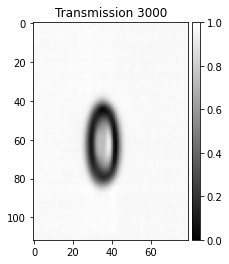

In [14]:
ImgIdx = 3000
image_datasets['train'].__getitem__(ImgIdx)[0].shape
ImgTensor = 0
ImgMask = 0
[ImgTensor,ImgLabel,ImgIdx] = image_datasets['train'].__getitem__(ImgIdx)
# image = np.transpose(ImgTensor.numpy(), (1,2,0))
# print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
print('image tensor index: ', ImgIdx)
print('Cell Label: ',CellName[ImgLabel])

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = 0
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)
DisplayImage(image,image.min(),image.max(),ImgIdx)

In [15]:
def calc_loss(out, prediction, target, original, metrics, num_epochs, MSE_weight=0.5):
    if num_epochs < 20:
        CE = 0
        MSE = F.mse_loss(out, original)
        loss = MSE 
        metrics['CE'] += CE
    else:
        CE = F.cross_entropy(prediction, target)
#     BCE = F.binary_cross_entropy_with_logits(prediction, target)
#     out = torch.sigmoid(out)
        MSE = F.mse_loss(out, original)
    
        loss = MSE * MSE_weight + CE * (1 - MSE_weight)
#     loss = MSE * MSE_weight + CE
    
        metrics['CE'] += CE.data.cpu().numpy() * target.size(0)
    metrics['MSE'] += MSE.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [16]:
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_MSEloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(2, 2)
            for inputs, labels,index in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                if epoch < 5:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs,predictions = model(inputs)
                    prediction = nn.functional.log_softmax(predictions,dim=1)
                    loss = calc_loss(outputs, predictions,labels,inputs, metrics, epoch,MSE_weight = 0.9)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(predictions, 1)
                # statistics
                epoch_samples += inputs.size(0)
                # statistics
                for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                  
                running_corrects += torch.sum(preds == labels.data)
            
            
            confusionMat = np.asarray(confusion_matrix)
            sumconfusion = np.sum(confusionMat,axis = 1).T

            summat = np.tile(sumconfusion,(2,1)).T
            # print(test)
            percentconfusion = np.divide(confusionMat,summat)
            epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/2
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = running_corrects.double() / epoch_samples
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_MSEloss_history.append(metrics['MSE']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                elif epoch > num_epochs * (1/3):
                    scheduler2.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
        
        if epoch > 3 and val_MSEloss_history[-1] > 1.8e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc_history,train_loss_history,val_acc_history,val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [17]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 256
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [18]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,1):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 2
    in_channel = 1
    out_channel = 1
    num_epochs = 150
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNetSmallBeads(in_channel,out_channel,num_class)
        model.apply(init_weights)
        model = model.to(device)

        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=1e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(), lr=1e-3,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        # optimizer_ft1 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # optimizer_ft2 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       
        model, scratch_hist_train,loss_hist_train,scratch_hist_val, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
#         print('model diverges, reinitializing training....\n')
#         print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        

Fold- 0 : Initializing Datasets and Dataloaders...
Epoch 0/149
----------
LR 1e-05
train: CE: 0.000000, MSE: 1.299048, loss: 1.299048
train Acc: 0.5000
train Bal. Acc: 0.5000
val: CE: 0.000000, MSE: 1.300924, loss: 1.300924
val Acc: 0.5000
val Bal. Acc: 0.5000
saving best model
Total time: 0:00:04.063173
Epoch time: 0m 4s
Epoch 1/149
----------
LR 1e-05
train: CE: 0.000000, MSE: 1.298644, loss: 1.298644
train Acc: 0.5000
train Bal. Acc: 0.5000
val: CE: 0.000000, MSE: 1.300634, loss: 1.300634
val Acc: 0.5000
val Bal. Acc: 0.5000
Total time: 0:00:07.648981
Epoch time: 0m 4s
Epoch 2/149
----------
LR 1e-05
train: CE: 0.000000, MSE: 1.297415, loss: 1.297415
train Acc: 0.5000
train Bal. Acc: 0.5000
val: CE: 0.000000, MSE: 1.300343, loss: 1.300343
val Acc: 0.5000
val Bal. Acc: 0.5000
Total time: 0:00:11.207465
Epoch time: 0m 4s
Epoch 3/149
----------
LR 1e-05
train: CE: 0.000000, MSE: 1.296127, loss: 1.296127
train Acc: 0.5000
train Bal. Acc: 0.5000
val: CE: 0.000000, MSE: 1.300050, loss: 1.

train: CE: 0.006026, MSE: 0.005736, loss: 0.005765
train Acc: 0.9984
train Bal. Acc: 0.9984
val: CE: 0.010425, MSE: 0.015860, loss: 0.015317
val Acc: 0.9975
val Bal. Acc: 0.9975
Total time: 0:01:58.823163
Epoch time: 0m 4s
Epoch 33/149
----------
LR 0.001
train: CE: 0.005215, MSE: 0.004040, loss: 0.004158
train Acc: 0.9984
train Bal. Acc: 0.9984
val: CE: 0.029895, MSE: 0.004044, loss: 0.006629
val Acc: 0.9925
val Bal. Acc: 0.9925
Total time: 0:02:02.377103
Epoch time: 0m 4s
Epoch 34/149
----------
LR 0.001
train: CE: 0.005445, MSE: 0.002805, loss: 0.003069
train Acc: 0.9984
train Bal. Acc: 0.9984
val: CE: 0.009789, MSE: 0.002649, loss: 0.003363
val Acc: 0.9975
val Bal. Acc: 0.9975
Total time: 0:02:05.938436
Epoch time: 0m 4s
Epoch 35/149
----------
LR 0.001
train: CE: 0.003418, MSE: 0.002052, loss: 0.002189
train Acc: 0.9997
train Bal. Acc: 0.9997
val: CE: 0.019790, MSE: 0.004619, loss: 0.006136
val Acc: 0.9975
val Bal. Acc: 0.9975
Total time: 0:02:09.487235
Epoch time: 0m 4s
Epoch 36/

train: CE: 0.001503, MSE: 0.000102, loss: 0.000242
train Acc: 0.9997
train Bal. Acc: 0.9997
val: CE: 0.007020, MSE: 0.000100, loss: 0.000792
val Acc: 0.9988
val Bal. Acc: 0.9987
Total time: 0:03:54.233086
Epoch time: 0m 4s
Epoch 65/149
----------
LR 0.0005
train: CE: 0.001009, MSE: 0.000136, loss: 0.000224
train Acc: 0.9997
train Bal. Acc: 0.9997
val: CE: 0.027579, MSE: 0.001902, loss: 0.004469
val Acc: 0.9950
val Bal. Acc: 0.9950
Total time: 0:03:57.791432
Epoch time: 0m 4s
Epoch 66/149
----------
LR 0.0005
train: CE: 0.000731, MSE: 0.000097, loss: 0.000161
train Acc: 0.9997
train Bal. Acc: 0.9997
val: CE: 0.008725, MSE: 0.000311, loss: 0.001152
val Acc: 0.9975
val Bal. Acc: 0.9975
Total time: 0:04:01.346233
Epoch time: 0m 4s
Epoch 67/149
----------
LR 0.0005
train: CE: 0.001227, MSE: 0.000104, loss: 0.000216
train Acc: 0.9997
train Bal. Acc: 0.9997
val: CE: 0.020896, MSE: 0.000671, loss: 0.002694
val Acc: 0.9975
val Bal. Acc: 0.9975
Total time: 0:04:04.903564
Epoch time: 0m 4s
Epoch 

train: CE: 0.000201, MSE: 0.000069, loss: 0.000082
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.009744, MSE: 0.000058, loss: 0.001026
val Acc: 0.9988
val Bal. Acc: 0.9987
Total time: 0:05:44.868204
Epoch time: 0m 4s
Epoch 96/149
----------
LR 3.125e-05
train: CE: 0.000246, MSE: 0.000067, loss: 0.000084
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.009650, MSE: 0.000056, loss: 0.001016
val Acc: 0.9975
val Bal. Acc: 0.9975
Total time: 0:05:48.423004
Epoch time: 0m 4s
Epoch 97/149
----------
LR 3.125e-05
train: CE: 0.000217, MSE: 0.000070, loss: 0.000085
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.009855, MSE: 0.000057, loss: 0.001037
val Acc: 0.9988
val Bal. Acc: 0.9987
Total time: 0:05:52.221863
Epoch time: 0m 4s
Epoch 98/149
----------
LR 3.125e-05
train: CE: 0.000182, MSE: 0.000070, loss: 0.000081
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.011232, MSE: 0.000056, loss: 0.001174
val Acc: 0.9975
val Bal. Acc: 0.9975
Epoch    48: reducing learning rate of gro

val: CE: 0.009566, MSE: 0.000056, loss: 0.001007
val Acc: 0.9988
val Bal. Acc: 0.9987
Total time: 0:07:32.518671
Epoch time: 0m 4s
Epoch 126/149
----------
LR 1.953125e-06
train: CE: 0.000181, MSE: 0.000070, loss: 0.000081
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.009750, MSE: 0.000056, loss: 0.001025
val Acc: 0.9988
val Bal. Acc: 0.9987
Epoch    76: reducing learning rate of group 0 to 9.7656e-07.
Total time: 0:07:36.060469
Epoch time: 0m 4s
Epoch 127/149
----------
LR 9.765625e-07
train: CE: 0.000180, MSE: 0.000071, loss: 0.000082
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.009724, MSE: 0.000056, loss: 0.001023
val Acc: 0.9988
val Bal. Acc: 0.9987
Total time: 0:07:39.624272
Epoch time: 0m 4s
Epoch 128/149
----------
LR 9.765625e-07
train: CE: 0.000227, MSE: 0.000070, loss: 0.000086
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.009424, MSE: 0.000056, loss: 0.000993
val Acc: 0.9988
val Bal. Acc: 0.9987
Total time: 0:07:43.186077
Epoch time: 0m 4s
Epoch 129/149
-

In [19]:
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist , delimiter=",")

fname23 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,train_Bacc_hist , delimiter=",")
fname24 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname24,val_Bacc_hist , delimiter=",")
fname25 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname25,lr_hist , delimiter=",")

150


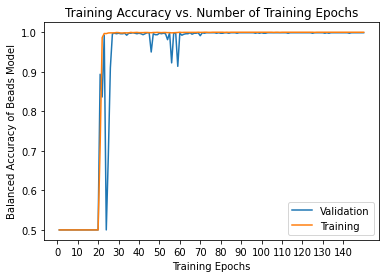

In [20]:
shist = []
shist1 = []

shist = val_Bacc_hist
shist1 = train_Bacc_hist
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Balanced Accuracy of Beads Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
# plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_B'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

In [21]:
fname6 = 'celltypemodel-unet_DGBeads_Run_'+str(runs)+'.pth.tar'

torch.save(model.state_dict(),fname6)

150


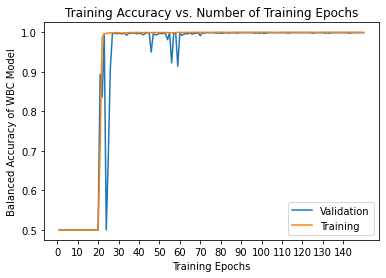

In [22]:
shist = []
shist1 = []

shist = val_Bacc_hist
shist1 = train_Bacc_hist
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Balanced Accuracy of WBC Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
# plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_B'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

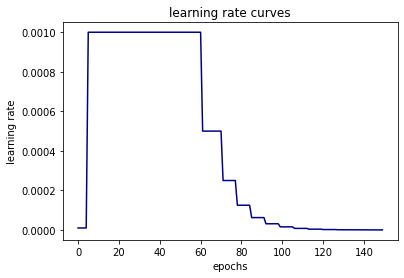

In [23]:
import pandas as pd
df = pd.read_csv (r'./learning_rate_0.csv',header=None)
LearnRate0 = df.to_numpy()
plt.figure()
plt.plot(LearnRate0,label = 'Fold-0', color='darkblue', linestyle = '-')
plt.title('learning rate curves')
plt.xlabel('epochs')
plt.ylabel('learning rate')
# plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

In [17]:
# Confusion Matrix
image_datasets = {}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)


In [18]:
num_class = 2
in_channel = 1
out_channel = 1
num_epochs = 150
scratch_model = UNetSmallBeads(in_channel,out_channel,num_class)
scratch_model.load_state_dict(torch.load('celltypemodel-unet_DGBeads_Run_0.pth.tar'))
scratch_model = scratch_model.to(device)
scratch_model.eval()

UNetSmallBeads(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=Tr

In [25]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 512
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


image tensor shape:  torch.Size([1, 112, 80])
image tensor dtype:  torch.float32
image tensor index:  500
Cell Label:  15$\mu$m
image shape:  (112, 80)


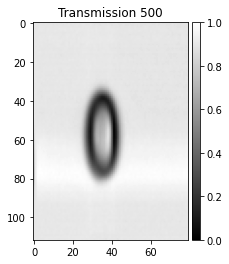

In [23]:
CellName = ['7$\mu$m','15$\mu$m']
ImgIdx = 500
image_datasets['val'].__getitem__(ImgIdx)[0].shape

ImgTensor = 0
ImgMask = 0
[ImgTensor,ImgLabel,ImgIdx] = image_datasets['val'].__getitem__(ImgIdx)
# image = np.transpose(ImgTensor.numpy(), (1,2,0))
# print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
print('image tensor index: ', ImgIdx)
print('Cell Label: ',CellName[ImgLabel])

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = 0
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)
DisplayImage(image,image.min(),image.max(),ImgIdx)

In [24]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes,index1) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs,predictions = scratch_model(inputs)
        prediction = nn.functional.log_softmax(predictions,dim=1)
        _, preds = torch.max(predictions, 1)
#         _, outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

tensor([[400.,   0.],
        [  0., 400.]])
[400. 400.]


In [25]:
percent_matrix = confusion_matrix/sumconfusion

percent_matrix = np.asarray(percent_matrix)
print(percent_matrix)

[[1. 0.]
 [0. 1.]]


In [30]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==1:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=(3, 3), dpi=500)
    sns.set(font_scale=1.3)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

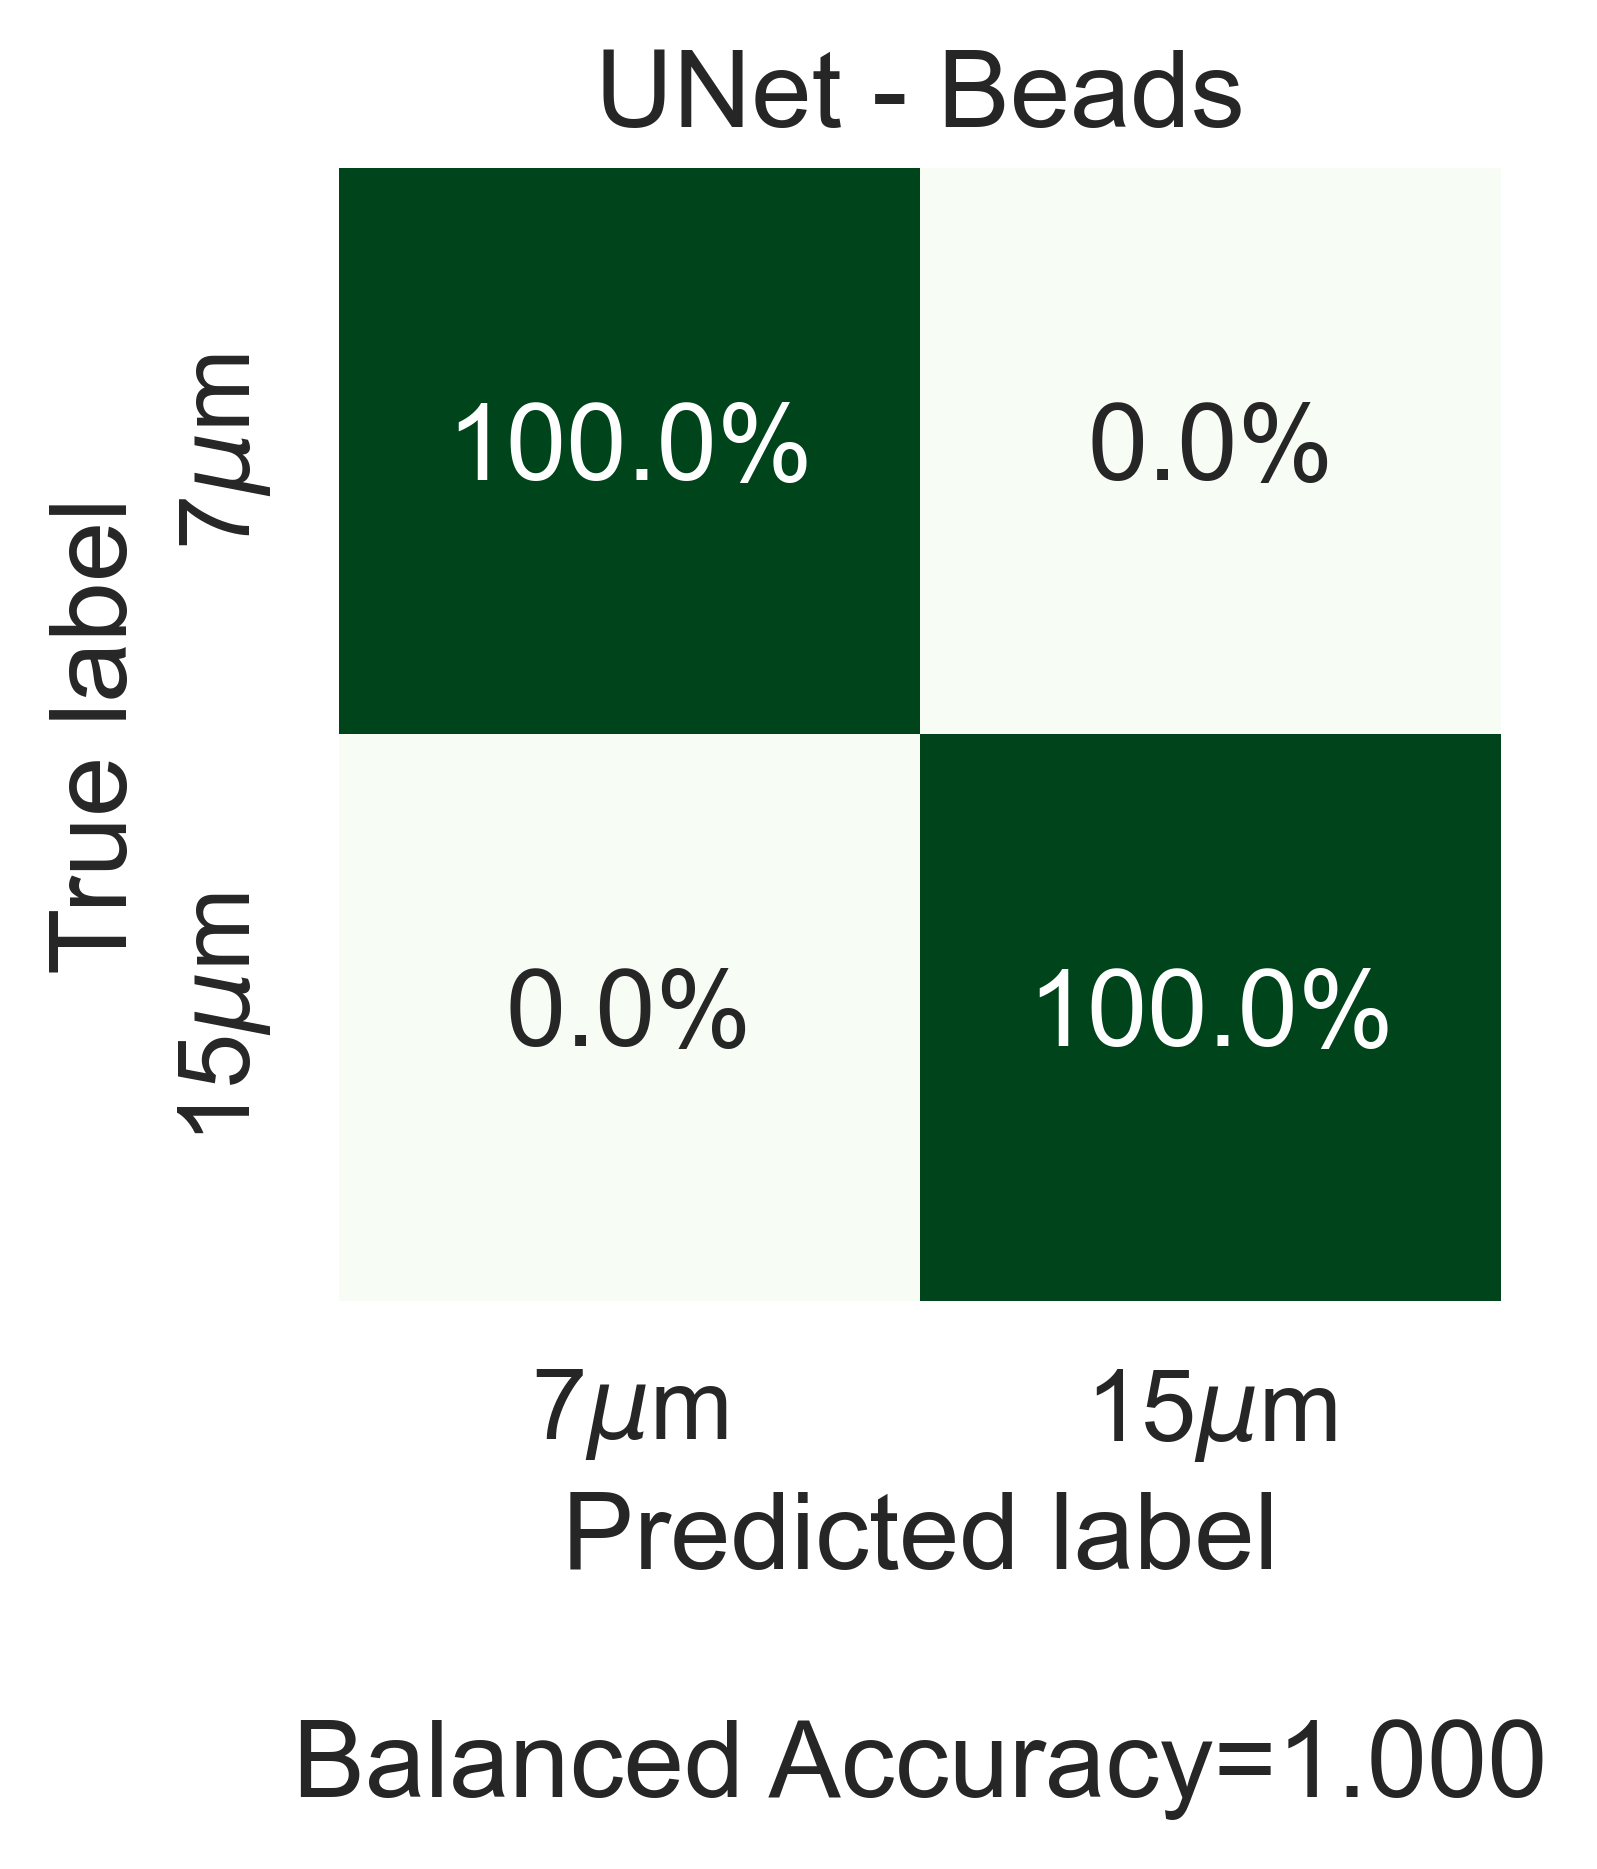

In [31]:
categories = CellName
make_confusion_matrix(percent_matrix, categories=categories,percent=False,cbar=False,figsize=(4 ,4),cmap='Greens',title = 'UNet - Beads')

In [19]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0),-1)

In [20]:
class maxpool(nn.Module):
    def __init__(self):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.maxpool(x)
        return x

In [21]:
class relu(nn.Module):
    def __init__(self):
        super(relu, self).__init__()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(x)
        return x

In [22]:
num_class = 2
in_channel = 1
out_channel = 1
num_epochs = 150
scratch_model = UNetSmallBeads(in_channel,out_channel,num_class)
scratch_model.load_state_dict(torch.load('celltypemodel-unet_DGBeads_Run_0.pth.tar'))
# scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),*(list(scratch_model.children())[4:5]),Flatten())
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[0:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),Flatten(),*(list(scratch_model.children())[-6:-4]),relu())
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (1): maxpool(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (3): maxpool(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [26]:
image_datasets = {}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)

In [27]:
with torch.no_grad():
    for i, (inputs, classes,imgidx) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs)
        outputs = outputs.cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [28]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

800
(800, 128)
(800,)
(800, 128)


In [29]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=40, learning_rate=200,early_exaggeration = 50, n_iter=500)
X_2d = tsne.fit_transform(outputlist)
CellName = ['7$\mu$m','15$\mu$m']

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.001s...
[t-SNE] Computed neighbors for 800 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 1.408040
[t-SNE] KL divergence after 250 iterations with early exaggeration: 342.744934
[t-SNE] KL divergence after 500 iterations: 0.317156


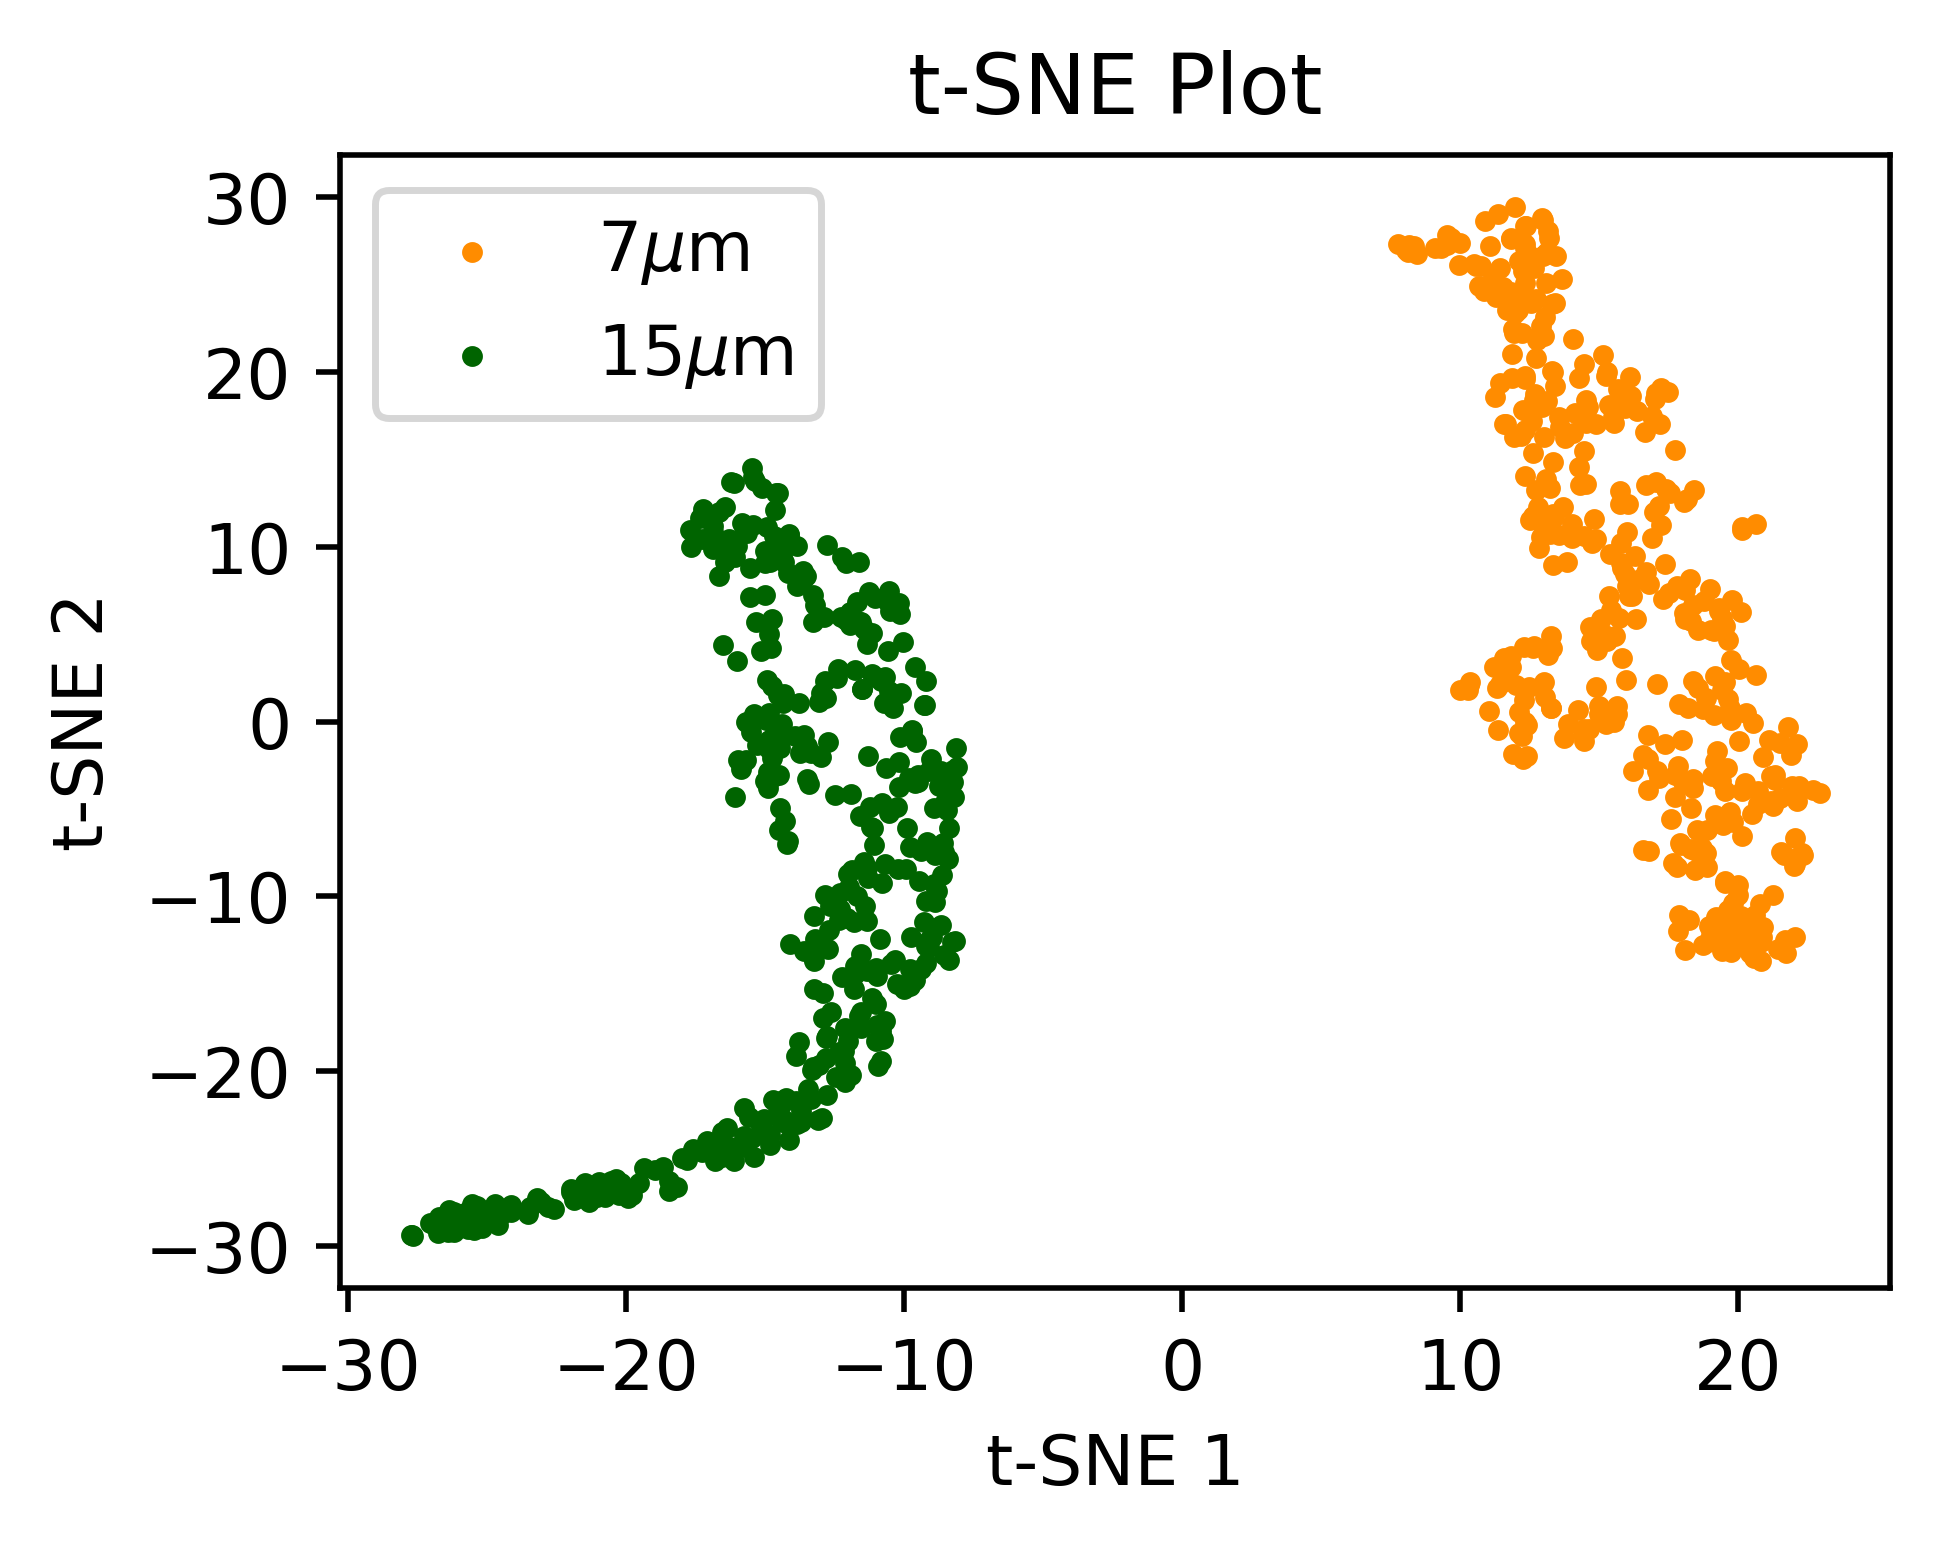

In [31]:
target_ids = range(len(outputlist))
plt.figure(figsize=(4, 3), dpi=500)
colors = 'darkorange', 'darkgreen', 'dodgerblue'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=4, c=c, label=label,alpha=1)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Plot')
plt.show()